Ejemplo:
clasificacion binaria para predecir la salud de una persona por medio de ciertas caracteristicas como el estilo de vida y la economia.

Primero importamos las librerias a utilizar

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

RSEED = 50

Luego ingresamos el dataset clean_data.csv (from:https://www.cdc.gov/) y o visualizamos 

In [ ]:
df = pd.read_csv('/content/clean_data.csv')
print(df.shape)
df.head()

(99719, 314)


,_STATE,FMONTH,DISPCODE,SEQNO,_PSU,CTELENUM,PVTRESD1,COLGHOUS,STATERES,CELLFON3,LADULT,NUMADULT,NUMMEN,NUMWOMEN,CTELNUM1,CELLFON2,CADULT,PVTRESD2,CCLGHOUS,CSTATE,LANDLINE,HHADULT,PERSDOC2,MEDCOST,CHECKUP1,BPHIGH4,BPMEDS,BLOODCHO,CHOLCHK,TOLDHI2,CVDINFR4,CVDCRHD4,CVDSTRK3,ASTHMA3,ASTHNOW,CHCSCNCR,CHCOCNCR,CHCCOPD1,HAVARTH3,ADDEPEV2,...,_VEG23,_FRUITEX,_VEGETEX,_TOTINDA,METVL11_,METVL21_,MAXVO2_,FC60_,ACTIN11_,ACTIN21_,PADUR1_,PADUR2_,PAFREQ1_,PAFREQ2_,_MINAC11,_MINAC21,STRFREQ_,PAMISS1_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_,_PACAT1,_PAINDX1,_PA150R2,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,49.0,4.0,1100.0,2.015009e+09,2.015009e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,NaN,1.0,1.0,3.0,1.0,2.0,1.0,3.0,NaN,1.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,...,1.0,5.397605e-79,5.397605e-79,1.0,35.0,5.397605e-79,3320.0,569.0,1.0,5.397605e-79,30.0,NaN,4000.0,NaN,120.0,5.397605e-79,5.397605e-79,5.397605e-79,120.0,5.397605e-79,120.0,5.397605e-79,5.397605e-79,5.397605e-79,3.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
1,9.0,9.0,1100.0,2.015005e+09,2.015005e+09,1.0,1.0,NaN,1.0,1.0,NaN,2.0,1.000000e+00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3.0,NaN,1.0,1.0,1.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,...,1.0,5.397605e-79,5.397605e-79,1.0,35.0,6.000000e+01,3745.0,642.0,1.0,1.000000e+00,60.0,30.0,7000.0,2333.0,420.0,7.000000e+01,5.397605e-79,5.397605e-79,420.0,7.000000e+01,490.0,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
2,34.0,10.0,1100.0,2.015011e+09,2.015011e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,NaN,1.0,1.0,4.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,...,1.0,5.397605e-79,5.397605e-79,1.0,35.0,3.300000e+01,3246.0,556.0,1.0,1.000000e+00,30.0,10.0,233.0,5000.0,7.0,5.000000e+01,5.397605e-79,5.397605e-79,7.0,5.000000e+01,57.0,5.397605e-79,5.397605e-79,5.397605e-79,3.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
3,41.0,4.0,1100.0,2.015002e+09,2.015002e+09,1.0,1.0,NaN,1.0,1.0,NaN,1.0,5.397605e-79,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,...,1.0,5.397605e-79,5.397605e-79,1.0,35.0,5.000000e+01,1507.0,258.0,2.0,2.000000e+00,30.0,30.0,5833.0,1000.0,175.0,3.000000e+01,5.397605e-79,5.397605e-79,350.0,6.000000e+01,410.0,1.750000e+02,3.000000e+01,2.050000e+02,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0
4,54.0,5.0,1100.0,2.015004e+09,2.015004e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,NaN,1.0,1.0,1.0,1.0,2.0,1.0,3.0,NaN,1.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,...,1.0,5.397605e-79,5.397605e-79,1.0,35.0,3.800000e+01,3431.0,588.0,1.0,1.000000e+00,30.0,15.0,3000.0,11667.0,90.0,1.750000e+02,2.000000e+03,5.397605e-79,90.0,1.750000e+02,265.0,5.397605e-79,5.397605e-79,5.397605e-79,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0


Exraemos las etiquetas

In [ ]:
labels = np.array(df.pop('label'))

Entrenamos los datos de prueba (30%=0.3)

In [ ]:
train, test, train_labels, test_labels = train_test_split(df,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.3, 
                                         random_state = RSEED)


In [ ]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())


In [ ]:
features = list(train.columns)

Creamos el modelo con 100 arboles

In [ ]:
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

Instanciamos los datos de entrenamiento

In [ ]:
model.fit(train, train_labels)


n_nodes = []
max_depths = []

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.1s finished


Vemos la cantidad de nodos y la profundidad que tienen los arboles en nuestro bosque

In [ ]:
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 13396
Average maximum depth 46


Prueba de entrenamiento para ver si hay sobreajuste

In [ ]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.6s finished


Prueba de prediccion para ver el desempeño

In [ ]:
rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.1s finished


Trazamos la curva ROC para el árbol de decisión único y el bosque aleatorio para ver los falsos positivos y los falsos negativos:

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    baseline = {}
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')

    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16

    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0


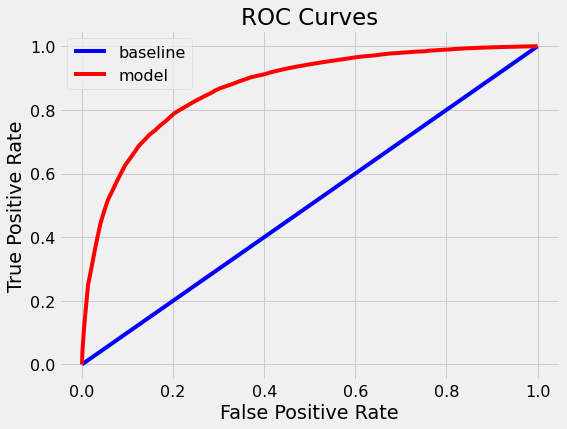

<Figure size 432x288 with 0 Axes>

In [ ]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')

ROC AUC para el bosque aleatorio fue de 0,87 aunque este sobre ajustado. El puntaje de entrenamientose logro llegar a 1.0 ROC AUC, que nuevamente es lo esperado porque le dimos a este modelo las respuestas de entrenamiento y no limitamos la profundidad máxima de cada árbol.

Otra medida de diagnóstico del modelo que podemos tomar es trazar la matriz de confusión para las predicciones de las pruebas:

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.show();


Confusion matrix, without normalization
[[ 2438  3136]
 [ 1043 23299]]


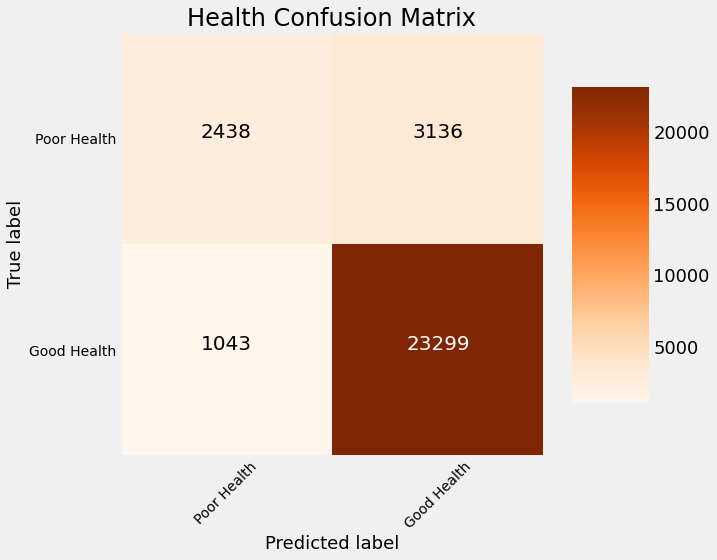

<Figure size 432x288 with 0 Axes>

In [ ]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

plt.savefig('cm.png')

Esto muestra las predicciones que el modelo acertó en las esquinas superior izquierda e inferior derecha y las predicciones perdidas por el modelo en la parte inferior izquierda y superior derecha.